# **Measuring Online Retail Sales Performance**

by Widi Hartati Ratu



In [11]:
# Import libraries
import pandas as pd
import numpy as np
import re
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
# Read data
df = pd.read_csv('/content/gdrive/MyDrive/online_retail_II.csv')

# **Data Attributes**
* Invoice : 6-digit invoice number assigned uniquely for each transaction. If this code starts with the letter 'C', it indicates cancellation.

* StockCode : Product code (item). A 5 digit number assigned uniquely to each different product.

* Description : Product name.

* Quantity : Total quantity of each product per transaction.

* InvoiceDate : The date and time of the invoice, i.e. the day and time the transaction was made.

* UnitPrice : Unit price or product price per unit in sterling (£).

* CustomerID : A 5-digit number that is uniquely assigned to each subscriber.

* Country : Name of the customer's country of residence.

# Data Quality Check

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


Terdapat 1067371 baris dan 8 kolom

In [16]:
#cek missing values
df.isnull().sum().sort_values(ascending=False)

,0
Customer ID,243007
Description,4382
Invoice,0
StockCode,0
Quantity,0
InvoiceDate,0
Price,0
Country,0


Terdapat missing values pada Customer ID dan description, hal ini dapat terjadi karena adanya cancelation.

In [17]:
df.duplicated().sum()

34335

In [18]:
duplicated_rows = df[df.duplicated()]
duplicated_rows.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34335 entries, 371 to 1067162
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Invoice      34335 non-null  object 
 1   StockCode    34335 non-null  object 
 2   Description  34228 non-null  object 
 3   Quantity     34335 non-null  int64  
 4   InvoiceDate  34335 non-null  object 
 5   Price        34335 non-null  float64
 6   Customer ID  26479 non-null  float64
 7   Country      34335 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 2.4+ MB


Bisa jadi duplikat value terjadi karena adanya pembelian berulan oleh customer yg sama. Untuk nomor invoice bisa terjadi sama dikarenakanadanya pembelian produk lebih dari 1 dari customer ID yg sama sehingga tercetak 1 invoice.

In [19]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [20]:
df.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


Kita cek terlebih dahulu untuk quantity dan price apakah ada yg minus?

In [21]:
df.Quantity.min()

-80995

Terdapat data yg perlu dihapus yaitu data yg quantity nya minus.

In [22]:
df = df[df['Quantity'] > 1].reset_index(drop=True)

In [23]:
df.Quantity.min()

2

In [24]:
df.Price.min()

0.0

In [25]:
df.describe()

,Quantity,Price,Customer ID
count,750075.000000,750075.000000,651937.000000
mean,15.169448,2.816494,15233.656841
std,152.574061,3.302429,1701.474267
min,2.000000,0.000000,12346.000000
25%,3.000000,1.250000,13800.000000
50%,6.000000,1.950000,15093.000000
75%,12.000000,3.750000,16728.000000
max,80995.000000,649.500000,18287.000000


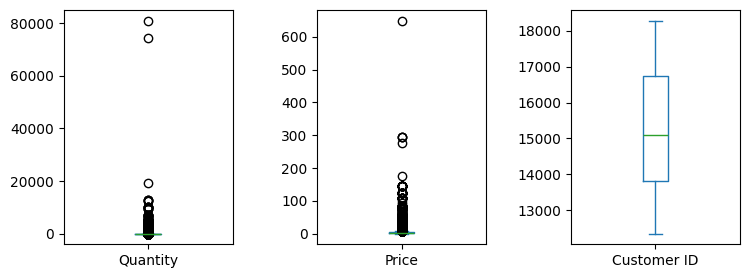

In [26]:
df_to_plot= df.select_dtypes(include=['float64', 'object','Int64'])

df_to_plot.plot(subplots=True, layout=(4,4), kind='box', figsize=(12,14))
plt.subplots_adjust(wspace=0.5);

terdapat data oulier di qty dan price, namun hal tersebut dapat terjadi.

# Analyzing Average Income per Year

Filter data
* No invoice tidak boleh berisi 'c' karena artinya customer melakukan cancel pembelanjaan.

In [27]:
df.insert(5, "Year", pd.DatetimeIndex(df['InvoiceDate']).year)

In [28]:
df.insert(5, "Month", pd.DatetimeIndex(df['InvoiceDate']).month)

In [29]:
sales = df[(df['Invoice'].str.contains('C') == False)
                   ]

Membuat kolom revenue

In [30]:
sales.insert(7, 'Revenue', (sales['Quantity'])*(sales['Price']))

In [31]:
sales

,Invoice,StockCode,Description,Quantity,InvoiceDate,Month,Year,Revenue,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,12,2009,83.40,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,12,2009,81.00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,12,2009,81.00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,12,2009,100.80,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,12,2009,30.00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...
750070,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,12,2011,10.20,0.85,12680.0,France
750071,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,12,2011,12.60,2.10,12680.0,France
750072,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,12,2011,16.60,4.15,12680.0,France
750073,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,12,2011,16.60,4.15,12680.0,France


# Average revenue per Year

In [32]:
sales1 = sales.groupby(['Year']).agg({'Revenue': 'mean'}).reset_index()
print(sales1)

   Year    Revenue
0  2009  25.023839
1  2010  25.106028
2  2011  25.132997


Text(0, 0.5, 'Mean Revenue')

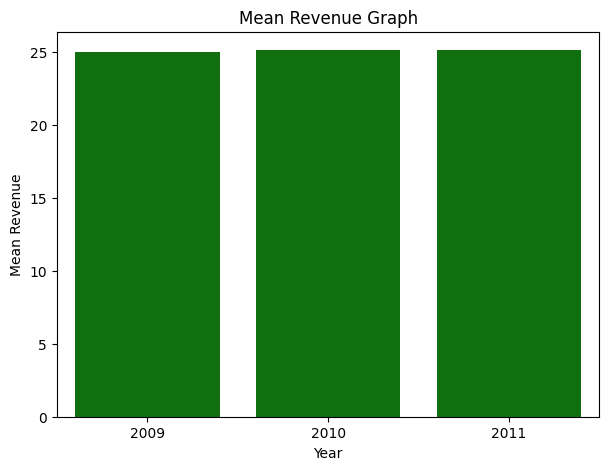

In [33]:
# Visualization
fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(data=sales1, x = 'Year',y='Revenue',
                color='green')
ax.set_title('Mean Revenue Graph')
ax.set_ylabel('Mean Revenue')

Setiap tahun revenue meningkat

# Analyzing Customer Transactions Per Year
Filtering Data
Customer yg menyelesaikan transaksi
Filter menggunakan 'sales' data dan customer ID tidak boleh kosong atau null yg artinya mereka tidak melakukan transaksi

In [41]:
finished = sales[(sales['Customer ID']!=0)]
finished

,Invoice,StockCode,Description,Quantity,InvoiceDate,Month,Year,Revenue,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,12,2009,83.40,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,12,2009,81.00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,12,2009,81.00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,12,2009,100.80,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,12,2009,30.00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...
750070,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,12,2011,10.20,0.85,12680.0,France
750071,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,12,2011,12.60,2.10,12680.0,France
750072,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,12,2011,16.60,4.15,12680.0,France
750073,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,12,2011,16.60,4.15,12680.0,France


Customer yg tidak jadi melakukan transaksi atau cancel

Kita filter menggunakan Invoice yg berisi huruf 'C' dan simpan menjadi variabel cancel


In [42]:
cancel = df[(df['Invoice'].str.contains('C') == True)]
print(cancel)

Empty DataFrame
Columns: [Invoice, StockCode, Description, Quantity, InvoiceDate, Month, Year, Price, Customer ID, Country]
Index: []


# Number of Finished and Canceled Transactions Each Year

In [43]:
# Finished
finished_count = finished.groupby(['Year']).agg({'Quantity': 'count'}).reset_index()
print(finished_count)

   Year  Quantity
0  2009     29095
1  2010    364835
2  2011    356145


In [44]:
# Canceled
canceled_count = cancel.groupby(['Year']).agg({'Quantity': 'count'}).reset_index()
print(canceled_count)

Empty DataFrame
Columns: [Year, Quantity]
Index: []


Text(0.5, 1.0, 'Canceled Transactions')

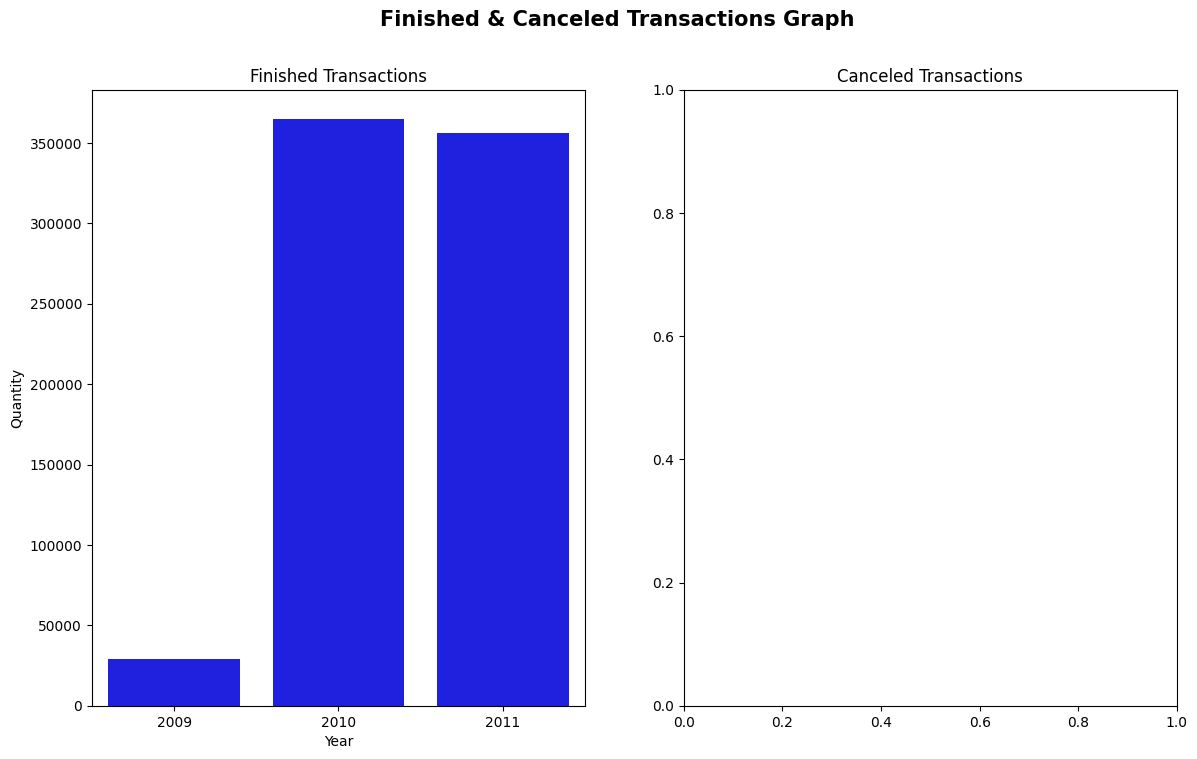

In [45]:
# Finished and canceled Visualization
fig, ax = plt.subplots(1,2,figsize=(14,8))
fig.suptitle('Finished & Canceled Transactions Graph', fontsize=15, fontweight='bold')

# subplot 1
sns.barplot(data=finished_count, x = 'Year', y='Quantity', color='blue', ax=ax[0])
ax[0].set_title('Finished Transactions')

# subplot 2
sns.barplot(data=canceled_count, x = 'Year', y='Quantity', color='red', ax=ax[1])
ax[1].set_title('Canceled Transactions')

Transaksi yg paling tinggi terjadi pada tahun 2010, dan tidak ada transaksi yg di cancel.

In [ ]:
# Finished and canceled Visualization
fig, ax = plt.subplots(1,2,figsize=(14,8))
fig.suptitle('Finished & Canceled Transactions Graph', fontsize=15, fontweight='bold')

# subplot 1
sns.barplot(data=finished_count, x = 'Year', y='Quantity', color='blue', ax=ax[0])
ax[0].set_title('Finished Transactions')

# subplot 2
sns.barplot(data=canceled_count, x = 'Year', y='Quantity', color='red', ax=ax[1])
ax[1].set_title('Canceled Transactions')

# Analyzing Revenue Every Month



In [57]:
import pandas as pd

df['Month'] = pd.to_datetime(df['Month'], errors='coerce') # handle potential errors during conversion

# Extract the month using the .dt accessor
df['Month'] = df['Month'].dt.month

In [71]:
sales2 = sales.groupby(['Month']).agg({'Revenue': 'mean'}).reset_index()
print(sales2)

    Month    Revenue
0       1  26.447031
1       2  24.664051
2       3  24.680760
3       4  23.758290
4       5  24.918044
5       6  24.900341
6       7  24.030245
7       8  26.247883
8       9  26.186419
9      10  23.950909
10     11  24.216146
11     12  27.302000


<ipython-input-73-7f7b8aed266d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales2, x = 'Month', y='Revenue',
<ipython-input-73-7f7b8aed266d>:4: UserWarning: 
The palette list has fewer values (1) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=sales2, x = 'Month', y='Revenue',


Text(0, 0.5, 'Mean Revenue')

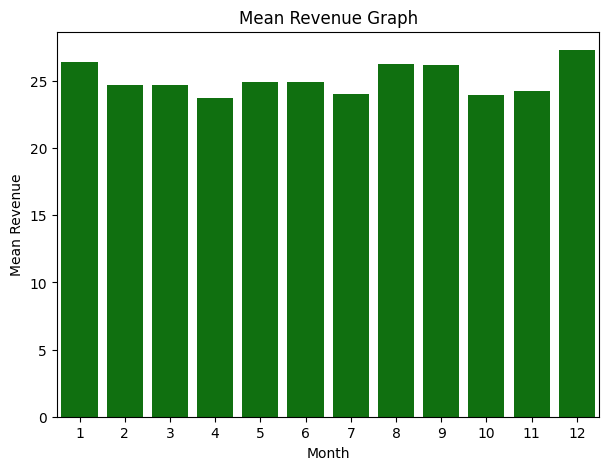

In [73]:
# Visualization
fig, ax = plt.subplots(figsize=(7,5))
# Change color='green, yellow, red' to palette=['green', 'yellow', 'red']
sns.barplot(data=sales2, x = 'Month', y='Revenue',
                palette=['green']) # Use palette for multiple colors
ax.set_title('Mean Revenue Graph')
ax.set_ylabel('Mean Revenue')


Transaksi paling banyak terjadi di bulan desember atau akhir tahun

Konklusi:
1. Setiap tahun terjadi peningkatan revenue
2. Pada bulan desember terjadi peningkatan revenue
3. Tidak adanya customer yg melakukan cancel transaki